<a href="https://colab.research.google.com/github/irkian/Brain_Tumor_Classifier/blob/main/BrainTumorClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataDir ='/content/drive/My Drive/Colab Notebooks/BrainTumorClassification'


In [4]:
print(os.listdir(dataDir))
classes = os.listdir(dataDir+'/Training')
print(classes)

['Testing', 'Training', 'BrainTumorClassifier.ipynb', 'Copy of BrainTumorClassifier.ipynb']
['pituitary', 'notumor', 'meningioma', 'glioma']


In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [6]:
trainDir = dataDir+'/Training'
testDir = dataDir+'/Testing'

trainDir, testDir

('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training',
 '/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing')

In [7]:
dataset = ImageFolder(trainDir, transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
]))

In [8]:
dataset

Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [9]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 64, 64]) 0


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [10]:
print(dataset.classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [12]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  glioma (0)


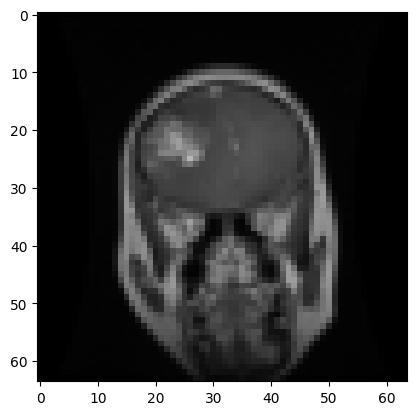

In [13]:
show_example(*dataset[0])


Label:  glioma (0)


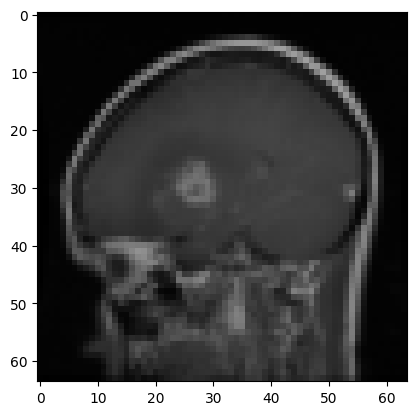

In [14]:
show_example(*dataset[1099])

In [15]:
random_seed = 42
torch.manual_seed(random_seed);

In [16]:
val_size = 500
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(5212, 500)

In [17]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [18]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [19]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

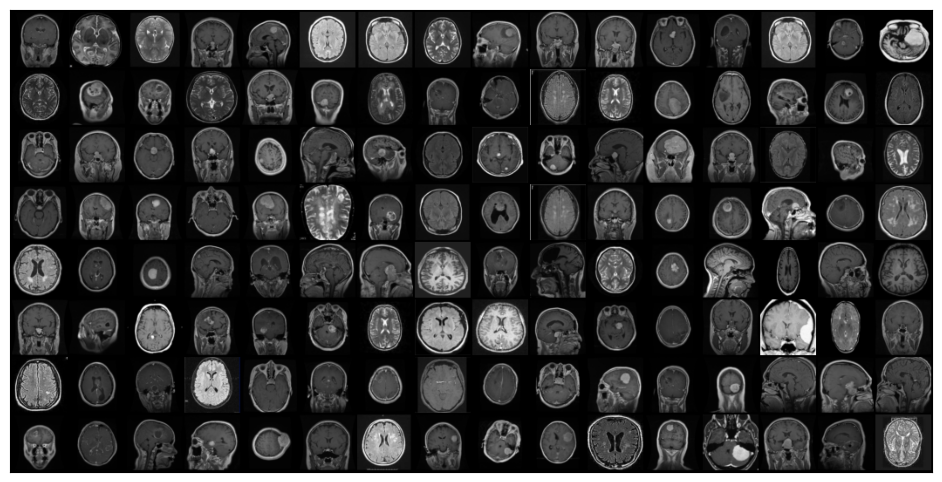

In [20]:
show_batch(train_dl)

In [21]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [22]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [25]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 8, 32, 32])


In [26]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [27]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*8*8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

In [28]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [29]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 64, 64])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0092,  0.0296, -0.0014, -0.0432, -0.0455, -0.0408, -0.0110,  0.0095,
         0.0261, -0.0244], grad_fn=<SelectBackward0>)


In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [33]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [34]:
model = to_device(Cifar10CnnModel(), device)


In [35]:
evaluate(model, val_dl)


{'val_loss': 2.3040385246276855, 'val_acc': 0.0}

In [36]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [37]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.6372, val_loss: 1.4061, val_acc: 0.2561
Epoch [1], train_loss: 1.1834, val_loss: 0.9976, val_acc: 0.5539
Epoch [2], train_loss: 0.8737, val_loss: 0.8992, val_acc: 0.6078
Epoch [3], train_loss: 0.6390, val_loss: 0.5075, val_acc: 0.8118
Epoch [4], train_loss: 0.4950, val_loss: 0.4434, val_acc: 0.8096
Epoch [5], train_loss: 0.4170, val_loss: 0.4267, val_acc: 0.8137
Epoch [6], train_loss: 0.3685, val_loss: 0.3185, val_acc: 0.8696
Epoch [7], train_loss: 0.3131, val_loss: 0.2998, val_acc: 0.8895
Epoch [8], train_loss: 0.2994, val_loss: 0.2840, val_acc: 0.9017
Epoch [9], train_loss: 0.2457, val_loss: 0.2245, val_acc: 0.9160


In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

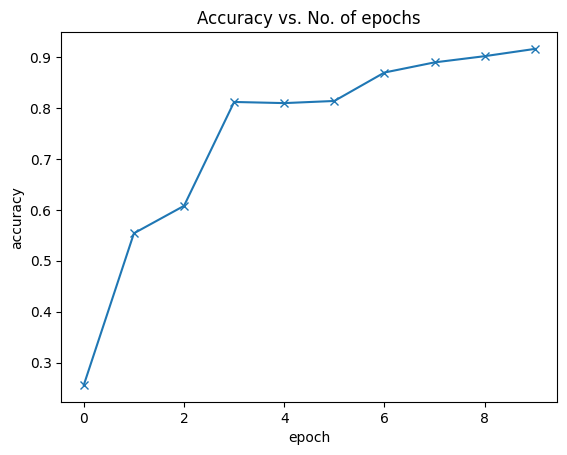

In [39]:
plot_accuracies(history)


In [40]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

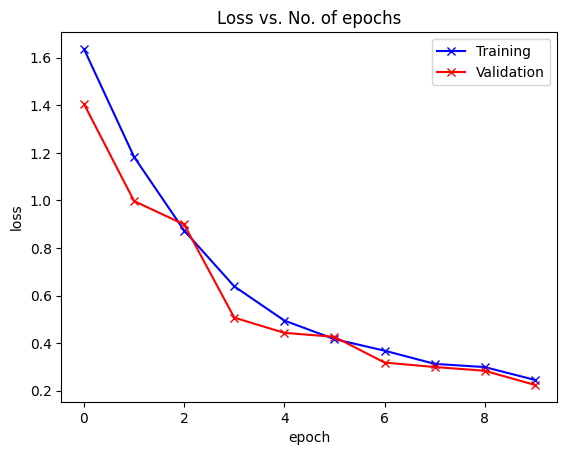

In [41]:
plot_losses(history)
